In [220]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.metrics import accuracy_score, classification_report

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [221]:
df = pd.read_csv('monthly_FRED-MD_2024-12_processed.csv')

# Deep Learning

In [222]:
NUMBER_OF_LAGS = 7
TRAIN_RATIO = 0.8
HIDDEN_DIM = 32
NUM_LAYERS = 1
DROPOUT = 0.2
LR = 3e-4
BATCH_SIZE = 64
EPOCHS = 50
CLASS_THRESHOLD = 0.5

In [223]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [224]:
# Keep only numeric features (drop target)
numeric = df.select_dtypes(include=[np.number]).copy()
X_all = numeric.drop(columns=["sign", "volatility"]).values
y_sign = numeric["sign"].astype(int).values


In [225]:
# Create sliding-window sequences
def create_sequences(X, y_sign, window):
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window : i, :])
        ys.append(y_sign[i])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_all, y_sign, NUMBER_OF_LAGS)

In [226]:
s = pd.Series(y_sign, name='sign')
lag_df = pd.DataFrame({
    'lag_t-1': s.shift(1),
    'lag_t-2': s.shift(2),
    'lag_t-3': s.shift(3),
    'sign_t': s
})

In [227]:
lag_df = lag_df.iloc[3:,].copy()
# count how often lag_t-1 = 1 if sign_t = 1
lag_df['lag_t-1_given_sign_t'] = lag_df['lag_t-1'] * lag_df['sign_t']
lag_df['lag_t-2_given_sign_t'] = lag_df['lag_t-2'] * lag_df['sign_t']
lag_df['lag_t-3_given_sign_t'] = lag_df['lag_t-3'] * lag_df['sign_t']
print(lag_df['lag_t-1_given_sign_t'].sum()/len(lag_df))
print(lag_df['lag_t-2_given_sign_t'].sum()/len(lag_df))
print(lag_df['lag_t-3_given_sign_t'].sum()/len(lag_df))

0.4083969465648855
0.366412213740458
0.38040712468193383


In [228]:
lag_df

,lag_t-1,lag_t-2,lag_t-3,sign_t,lag_t-1_given_sign_t,lag_t-2_given_sign_t,lag_t-3_given_sign_t
3,1.0,1.0,1.0,0,0.0,0.0,0.0
4,0.0,1.0,1.0,1,0.0,1.0,1.0
5,1.0,0.0,1.0,0,0.0,0.0,0.0
6,0.0,1.0,0.0,0,0.0,0.0,0.0
7,0.0,0.0,1.0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
784,1.0,1.0,0.0,1,1.0,1.0,0.0
785,1.0,1.0,1.0,0,0.0,0.0,0.0
786,0.0,1.0,1.0,1,0.0,1.0,1.0
787,1.0,0.0,1.0,1,1.0,0.0,1.0


In [229]:
train_size = int(len(X_seq) * TRAIN_RATIO)
X_train = X_seq[:train_size]; X_test = X_seq[train_size:]
ys_train = y_seq[:train_size]; ys_test = y_seq[train_size:]

In [230]:
# Torch datasets
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
ys_train_t = torch.tensor(ys_train, dtype=torch.float32).unsqueeze(1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_t, ys_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Define LSTM Model

In [231]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, num_layers=1, dropout=0.0):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out)

input_dim = X_train.shape[2]
model = SimpleLSTM(input_dim=input_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCELoss()

C:\Users\jdobe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [232]:
model

SimpleLSTM(
  (lstm): LSTM(113, 32, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Model Training

X_train_t contains batch size, sequence length (number of lags) and number of variables.
Pytorch automatically calls forward()-method when input is given to the model.

In [233]:
model.train()
for epoch in range(EPOCHS+1):     # number of seeing the training data for learning parameters
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")

Epoch 0: loss = 0.7051
Epoch 10: loss = 0.6850
Epoch 20: loss = 0.6823
Epoch 30: loss = 0.6808
Epoch 40: loss = 0.6724
Epoch 50: loss = 0.6643


### Out of sample Prediction

In [234]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).squeeze().numpy()
    y_pred_sign = (y_pred_test > CLASS_THRESHOLD).astype(int)

In [235]:
acc = accuracy_score(ys_test, y_pred_sign)
print(f"Test accuracy (sign): {acc:.4f}")
print("Classification report (sign):")
print(classification_report(ys_test, y_pred_sign, digits=4))

Test accuracy (sign): 0.6752
Classification report (sign):
              precision    recall  f1-score   support

           0     0.2857    0.0417    0.0727        48
           1     0.6933    0.9541    0.8031       109

    accuracy                         0.6752       157
   macro avg     0.4895    0.4979    0.4379       157
weighted avg     0.5687    0.6752    0.5798       157



# Model Diagnostics

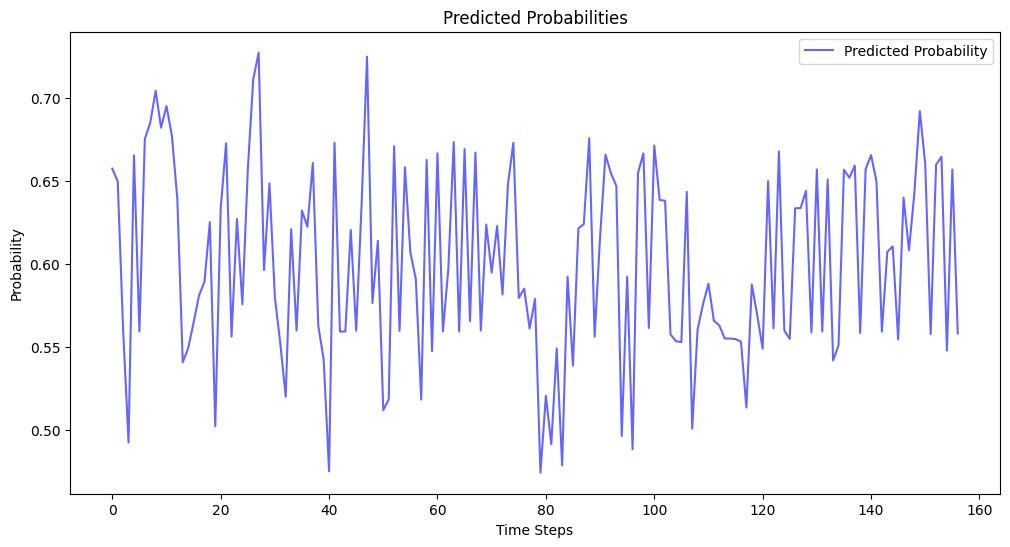

In [236]:
# plot probabilities
plt.figure(figsize=(12,6))
plt.plot(y_pred_test, label='Predicted Probability', color='blue', alpha=0.6)
plt.title('Predicted Probabilities')
plt.xlabel('Time Steps')
plt.ylabel('Probability')
plt.legend()
plt.show()

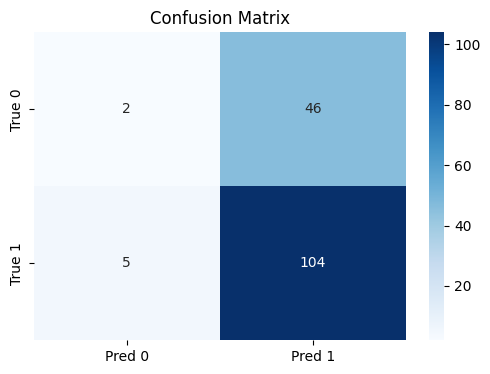

In [237]:
# create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(ys_test, y_pred_sign)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.show()

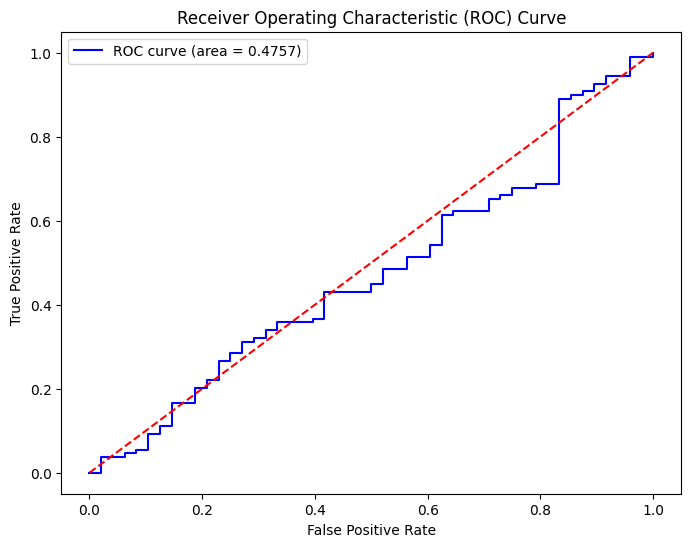

In [238]:
# roc curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(ys_test, y_pred_test)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()